交叉验证对比（5 折 macro F1）：
logreg : 0.6751
rf     : 0.7907
gbc    : 0.7927
voting : 0.7954

选择得分最高的模型: voting

=== Test Metrics ===
Balanced Accuracy: 0.8053
Macro F1: 0.8062

Classification Report:
              precision    recall  f1-score   support

       Bumps     0.6988    0.7160    0.7073        81
   Dirtiness     0.8182    0.8182    0.8182        11
    K_Scatch     0.9730    0.9231    0.9474        78
Other_Faults     0.7519    0.7407    0.7463       135
      Pastry     0.5789    0.6875    0.6286        32
      Stains     0.9231    0.8571    0.8889        14
   Z_Scratch     0.9189    0.8947    0.9067        38

    accuracy                         0.7892       389
   macro avg     0.8090    0.8053    0.8062       389
weighted avg     0.7953    0.7892    0.7916       389

Confusion Matrix (rows=true, cols=pred):
              Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  \
Pastry            22          0         0       0          0      3   
Z_Scratch          0      

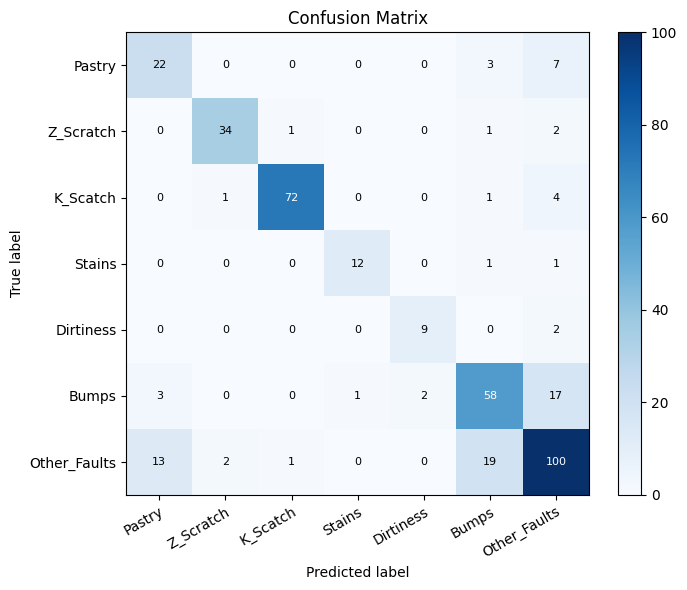

Top3 Accuracy (soft voting style): 0.4062
ROC-AUC macro (ovr): 0.5663
ROC-AUC micro:      0.5573
ROC curves figure saved to: outputs/roc_auc.png


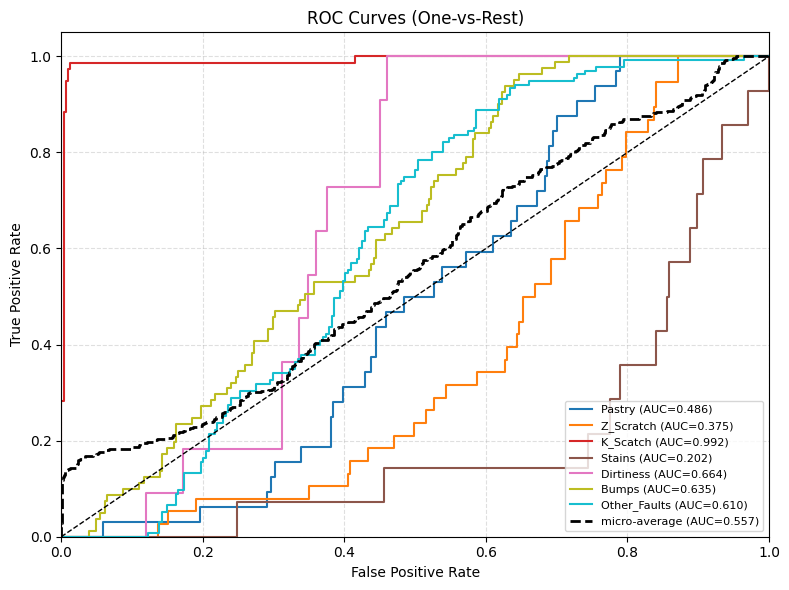


脚本完成。


In [4]:
from __future__ import annotations

import itertools
import os
from pathlib import Path
import io
import zipfile
import urllib.request
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize

try:
    from ucimlrepo import fetch_ucirepo
except ImportError:  # 库未安装时保持兼容
    fetch_ucirepo = None

SEED = 42
DATA_URLS = [
    # UCI 新站点 zip 下载
    "https://archive.ics.uci.edu/static/public/198/steel+plates+faults.zip",
    # 官方 UCI（http 更稳定）
    "http://archive.ics.uci.edu/ml/machine-learning-databases/00192/Faults.NNA",
    # GitHub 备用镜像 1
    "https://raw.githubusercontent.com/selva86/datasets/master/Faults.NNA",
    # GitHub 备用镜像 2（CSV 版本）
    "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/faults.csv",
]
CLASS_NAMES = [
    "Pastry",
    "Z_Scratch",
    "K_Scatch",
    "Stains",
    "Dirtiness",
    "Bumps",
    "Other_Faults",
]


def ensure_data(local_path: Path) -> Path:

    local_path.parent.mkdir(parents=True, exist_ok=True)
    if local_path.exists():
        return local_path
    # 用户已手动放置的常见文件名
    for candidate in ["Faults.NNA", "faults.csv", "Faults27x7_var", "faults.NNA"]:
        cand_path = local_path.parent / candidate
        if cand_path.exists():
            return cand_path
    last_error = None

    # 优先使用 ucimlrepo（UCI 官方推荐方式），避免 404
    if fetch_ucirepo is not None:
        try:
            ds = fetch_ucirepo(id=198)
            df = pd.concat([ds.data.features, ds.data.targets], axis=1)
            df.to_csv(local_path, index=False, header=False)
            return local_path
        except Exception as exc:  # noqa: BLE001
            last_error = exc

    for url in DATA_URLS:
        try:
            if url.endswith(".zip"):
                with urllib.request.urlopen(url) as resp:
                    data = resp.read()
                with zipfile.ZipFile(io.BytesIO(data)) as zf:
                    member = None
                    for name in zf.namelist():
                        if name.lower().endswith("faults.nna"):
                            member = name
                            break
                        if name.lower().endswith(".csv"):
                            member = name
                    if member is None:
                        raise FileNotFoundError("zip 内未找到 Faults.NNA/CSV")
                    with zf.open(member) as f:
                        sep = ";" if member.lower().endswith("nna") else ","
                        df = pd.read_csv(f, header=None, sep=sep)
            else:
                # UCI/selva86 使用分号分隔，stedy 镜像是逗号
                sep = ";" if url.endswith("Faults.NNA") else ","
                df = pd.read_csv(url, header=None, sep=sep)

            df.to_csv(local_path, index=False, header=False)
            return local_path
        except Exception as exc:  # noqa: BLE001
            last_error = exc
    raise RuntimeError(f"数据下载失败，最后错误：{last_error}")
    return local_path


def load_dataset(csv_path: Path) -> Tuple[pd.DataFrame, pd.Series]:
    """
    数据集前 27 列为特征，后 7 列为独热标签。
    """

    for sep in (";", ",", r"\s+"):
        try:
            df = pd.read_csv(csv_path, header=None, sep=sep)
            if df.shape[1] >= 34:  # 预期至少 34 列
                break
        except Exception:
            continue
    else:
        raise ValueError(f"无法解析数据文件: {csv_path}")

    feature_cols = [f"f{i+1}" for i in range(27)]
    label_cols = CLASS_NAMES
    df.columns = feature_cols + label_cols

    X = df[feature_cols]
    y_raw = df[label_cols]
    # 将独热编码转为单一类别标签
    target_idx = y_raw.values.argmax(axis=1)
    y = pd.Series([CLASS_NAMES[i] for i in target_idx], name="fault_type")
    return X, y


def build_models() -> Dict[str, Pipeline]:
    """
    构造若干模型与预处理
    """
    scaler = StandardScaler()
    logreg = LogisticRegression(
        multi_class="multinomial",
        class_weight="balanced",
        max_iter=300,
        C=2.0,
        n_jobs=-1,
        random_state=SEED,
    )
    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        class_weight="balanced_subsample",
        random_state=SEED,
        n_jobs=-1,
    )
    gbc = GradientBoostingClassifier(random_state=SEED)

    models = {
        "logreg": Pipeline([("scaler", scaler), ("clf", logreg)]),
        "rf": rf,
        "gbc": gbc,
    }
    # 软投票融合
    voting = VotingClassifier(
        estimators=[("lr", models["logreg"]), ("rf", rf), ("gbc", gbc)],
        voting="soft",
        weights=[2, 3, 2],
        n_jobs=-1,
    )
    models["voting"] = voting
    return models


def cv_score(model, X, y, folds: int = 5) -> float:
    """
    使用分层 K 折交叉验证评估 macro F1，兼顾类别不平衡。
    """
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)
    scores = cross_val_score(model, X, y, cv=skf, scoring="f1_macro", n_jobs=-1)
    return float(scores.mean())


def evaluate(model, X_test, y_test) -> None:
    """
    打印分类报告与混淆矩阵等指标，并绘制混淆矩阵/ROC 曲线。
    """
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    print("\n=== Test Metrics ===")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, pred):.4f}")
    print(f"Macro F1: {f1_score(y_test, pred, average='macro'):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, pred, digits=4))

    cm = confusion_matrix(y_test, pred, labels=CLASS_NAMES)
    cm_df = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm_df)

    # 保存混淆矩阵图
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set(
        xticks=np.arange(len(CLASS_NAMES)),
        yticks=np.arange(len(CLASS_NAMES)),
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES,
        ylabel="True label",
        xlabel="Predicted label",
        title="Confusion Matrix",
    )
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    # 在图中标注数值
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(
            j,
            i,
            format(cm[i, j], "d"),
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=8,
        )

    fig.tight_layout()
    out_dir = Path("outputs")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / "confusion_matrix.png"
    fig.savefig(out_path, dpi=150)
    print(f"Confusion matrix figure saved to: {out_path}")

    # 直接展示图像（阻塞，关闭窗口后继续）
    plt.show()
    plt.close(fig)

    if prob is not None:
        top5 = np.mean(
            [
                y_true in np.array(CLASS_NAMES)[np.argsort(p)[::-1][:3]]
                for y_true, p in zip(y_test, prob)
            ]
        )
        print(f"Top3 Accuracy (soft voting style): {top5:.4f}")

        # 多分类 ROC/AUC（one-vs-rest 微/宏）
        y_bin = label_binarize(y_test, classes=CLASS_NAMES)
        fpr: Dict[str, np.ndarray] = {}
        tpr: Dict[str, np.ndarray] = {}
        roc_auc: Dict[str, float] = {}

        for i, cls in enumerate(CLASS_NAMES):
            fpr[cls], tpr[cls], _ = roc_curve(y_bin[:, i], prob[:, i])
            roc_auc[cls] = auc(fpr[cls], tpr[cls])

        fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        auc_macro = roc_auc_score(y_bin, prob, average="macro", multi_class="ovr")
        auc_micro = roc_auc["micro"]
        print(f"ROC-AUC macro (ovr): {auc_macro:.4f}")
        print(f"ROC-AUC micro:      {auc_micro:.4f}")

        # 绘制 ROC 曲线
        fig2, ax2 = plt.subplots(figsize=(8, 6))
        colors = plt.cm.tab10(np.linspace(0, 1, len(CLASS_NAMES)))
        for color, cls in zip(colors, CLASS_NAMES):
            ax2.plot(
                fpr[cls],
                tpr[cls],
                label=f"{cls} (AUC={roc_auc[cls]:.3f})",
                color=color,
                linewidth=1.5,
            )
        ax2.plot(
            fpr["micro"],
            tpr["micro"],
            label=f"micro-average (AUC={roc_auc['micro']:.3f})",
            color="black",
            linestyle="--",
            linewidth=2,
        )
        ax2.plot([0, 1], [0, 1], "k--", lw=1)
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel("False Positive Rate")
        ax2.set_ylabel("True Positive Rate")
        ax2.set_title("ROC Curves (One-vs-Rest)")
        ax2.legend(loc="lower right", fontsize=8)
        ax2.grid(True, linestyle="--", alpha=0.4)
        fig2.tight_layout()
        roc_path = Path("outputs") / "roc_auc.png"
        roc_path.parent.mkdir(parents=True, exist_ok=True)
        fig2.savefig(roc_path, dpi=150)
        print(f"ROC curves figure saved to: {roc_path}")
        plt.show()
        plt.close(fig2)


def main() -> None:
    data_path = ensure_data(Path("data") / "steel_faults.csv")
    X, y = load_dataset(data_path)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    models = build_models()

    print("交叉验证对比（5 折 macro F1）：")
    cv_results = {}
    for name, model in models.items():
        score = cv_score(model, X_train, y_train, folds=5)
        cv_results[name] = score
        print(f"{name:7s}: {score:.4f}")

    best_model_name = max(cv_results, key=cv_results.get)
    best_model = models[best_model_name]
    print(f"\n选择得分最高的模型: {best_model_name}")

    best_model.fit(X_train, y_train)
    evaluate(best_model, X_test, y_test)

    print("\n脚本完成。")


if __name__ == "__main__":
    main()